# **Sentiment Analysis on Tweets**
Sentiment analysis, also known as opinion mining, is the process of identifying and categorizing emotions expressed in text data—typically as positive, negative, or neutral. It helps organizations and individuals understand the sentiment behind user-generated content, such as product reviews, social media posts, or customer feedback.

In the context of social media, sentiment analysis is particularly valuable due to the vast amount of real-time user opinions shared daily. Twitter, with its concise and public messages, provides an ideal dataset for analyzing public sentiment around topics, events, brands, or products.

By leveraging natural language processing (NLP) techniques and machine learning models, sentiment analysis can extract insights from tweets to support business decisions, brand monitoring, political analysis, and crisis management.

This project focuses on building a sentiment classifier using a dataset of tweets. The model aims to classify each tweet as positive or negative, helping reveal how people feel about certain topics at scale.

<br>

**Dataset:** [Kaggle Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140/data)

---

## **Data Preprocessing**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
# import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
# from nltk.tokenize import word_tokenize
import emoji

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Prepare the dataset.

In [5]:
dataset_path = 'twt.csv'
column_names = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv(dataset_path, encoding='latin', delimiter=',', names=column_names)
df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Drop unimportant columns and missing values.

In [6]:
df = df.drop(['id', 'date', 'flag', 'user'], axis=1)
df = df.dropna()
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Preprocess the data:
- convert the emojis into text
- lowercase everything
- remove urls, mentions and hashtags
- remove punctuations and special characters
- remove stopwords
- split into tokens

In [7]:
print("Sample stopwords being removed:")
print(list(stop_words))

Sample stopwords being removed:
["needn't", "we're", "wasn't", 'which', 'more', 'his', 'did', 'd', 'an', 'o', 'our', 'whom', "you're", 're', 'then', 'or', 'under', 'why', 'no', 'these', 'ma', "he'll", 'while', 'once', 'haven', 'themselves', 'just', 'same', 'nor', 'couldn', 'their', "we'd", 'in', 'yours', 'me', "we've", 'between', 'how', 'm', "you've", 'has', "she'll", 'on', 'ourselves', 's', 'when', 'have', 'about', 'very', 'wouldn', 'is', 'own', 'here', 'can', 'll', 'theirs', 'those', "he's", 'myself', 'needn', "isn't", 'other', 'it', "it'll", 'doesn', 'after', 'yourselves', 'we', 'ours', "don't", "that'll", "it's", 'didn', 'for', 'a', 'hasn', 'that', 'through', 'as', 'any', "didn't", 'you', 'below', "doesn't", 'he', 'been', "we'll", 'am', 'only', 'and', "should've", "mightn't", 'out', "they've", 'him', 'against', "she's", 'what', 'too', "shan't", 'this', 'who', "weren't", "i'd", "i'll", 'into', 'now', "couldn't", 'her', 'from', 'such', 'the', "wouldn't", "you'd", 'were', 'above', 'it

In [8]:
sentiment_critical = {
    'not', 'no', 'never', 'nothing', 'nobody', 'none', 'nowhere', 'neither',
    'very', 'really', 'quite', 'rather', 'extremely', 'incredibly', 'absolutely',
    'but', 'however', 'although', 'though', 'yet', 'except',
    'too', 'so', 'such', 'more', 'most', 'less', 'least',
    'only', 'just', 'still', 'even', 'again'
}

negative_contractions = {
    "don't", "won't", "can't", "shouldn't", "wouldn't", "couldn't",
    "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
    "hadn't", "doesn't", "didn't", "won't", "shan't", "mustn't",
    "mightn't", "needn't"
}

sentiment_critical.update(negative_contractions)

In [9]:
def clean_twts(twt):
    twt = twt.lower()
    twt = re.sub(r"http\S+|www\S+|https\S+", '', twt)  # remove urls
    twt = re.sub(r"@\w+", '', twt)  # remove mentions
    twt = re.sub(r"#", '', twt)  # remove hashtag symbol
    twt = emoji.replace_emoji(twt, replace='')  # remove emojis
    twt = re.sub(r"[^a-zA-Z\s']", '', twt)  # remove punctuation
    twt = re.sub(r"\s+", ' ', twt).strip()  # clean whitespace

    tokens = twt.split()
    tokens = [word for word in tokens if (word not in stop_words or word in sentiment_critical) and len(word) > 1] # remove stopwords and keep sentiment-critical words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # lemmatize

    return ' '.join(tokens)

cleaned_twts = df['text'].apply(clean_twts)
df['cleaned_text'] = cleaned_twts

In [10]:
# def clean_twts(twt):
#     twt = twt.lower()  # Lowercase
#     twt = re.sub(r"http\S+|www\S+|https\S+", '', twt)  # Remove URLs
#     twt = re.sub(r"@\w+", '', twt)  # Remove mentions
#     twt = re.sub(r"#", '', twt)  # Remove hashtag symbol, keep the word
#     twt = emoji.demojize(twt)  # Convert emojis to text
#     twt = re.sub(r"[^a-zA-Z\s]", '', twt)  # Remove punctuations and special characters
#     twt = re.sub(r"\s+", ' ', twt).strip()  # Remove extra spaces
#     tokens = twt.split()  # Tokenize
#     tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
#     tokens = [stemmer.stem(word) for word in tokens]  # Stem words

#     return ' '.join(tokens)

# cleaned_twts = df['text'].apply(clean_twts)
# df['cleaned_text'] = cleaned_twts

In [11]:
df.head()

,sentiment,text,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that's bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset can't update facebook texting might cry ...
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",no not behaving mad can't see


In [12]:
# Check average tweet length after preprocessing
lengths = [len(text.split()) for text in cleaned_twts]
print(f"Average length: {np.mean(lengths):.2f}")
print(f"95th percentile: {np.percentile(lengths, 95):.2f}")

Average length: 7.42
95th percentile: 15.00


Tokenize the data.

In [13]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(cleaned_twts)
sequences = tokenizer.texts_to_sequences(cleaned_twts)
padded_sequences = pad_sequences(sequences, maxlen=20, padding='post', truncating='post')

print("Tokenized and padded sequences:")
print(padded_sequences)

Tokenized and padded sequences:
[[  82 1059 3184 ...    0    0    0]
 [ 641   28  292 ...    0    0    0]
 [   1  222   17 ...    0    0    0]
 ...
 [ 131 7273 6824 ...    0    0    0]
 [  63  205  179 ...    0    0    0]
 [  63    1    0 ...    0    0    0]]


Add into the dataframe.

In [14]:
df['padded_text'] = list(padded_sequences)
df['sentiment'] = df['sentiment'].map({4: 1, 0: 0})
df.head()

,sentiment,text,cleaned_text,padded_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that's bummer shoulda got david carr third day,"[82, 1059, 3184, 18, 735, 8889, 1695, 6, 0, 0,..."
1,0,is upset that he can't update his Facebook by ...,upset can't update facebook texting might cry ...,"[641, 28, 292, 445, 1855, 198, 290, 987, 86, 1..."
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound,"[1, 222, 17, 861, 1480, 747, 368, 10, 2921, 0,..."
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire,"[329, 674, 43, 2669, 9, 999, 0, 0, 0, 0, 0, 0,..."
4,0,"@nationwideclass no, it's not behaving at all....",no not behaving mad can't see,"[11, 5, 9422, 487, 28, 27, 0, 0, 0, 0, 0, 0, 0..."


Split the dataset.

In [15]:
x = padded_sequences
y = df['sentiment']


x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build(input_shape=(None,20))

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,137 (2.58 MB)

 Trainable params: 675,137 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    x_train, y_train,
    epochs=12,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Epoch 1/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 205s 7ms/step - accuracy: 0.7689 - loss: 0.4758 - val_accuracy: 0.8056 - val_loss: 0.4196
Epoch 2/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 188s 6ms/step - accuracy: 0.8116 - loss: 0.4120 - val_accuracy: 0.8096 - val_loss: 0.4136
Epoch 3/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 202s 6ms/step - accuracy: 0.8221 - loss: 0.3927 - val_accuracy: 0.8105 - val_loss: 0.4134
Epoch 4/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 217s 7ms/step - accuracy: 0.8297 - loss: 0.3779 - val_accuracy: 0.8104 - val_loss: 0.4152
Epoch 5/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 260s 7ms/step - accuracy: 0.8370 - loss: 0.3639 - val_accuracy: 0.8094 - val_loss: 0.4177
Epoch 6/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 192s 6ms/step - accuracy: 0.8442 - loss: 0.3500 - val_accuracy: 0.8069 - val_loss: 0.4233
Epoch 7/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 201s 7ms/step - accuracy: 0.8514 - loss: 0.3368 - val_accuracy: 0.8040 - val_loss: 0.4305
Epoch 8/12
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 188s 6ms/step - ac

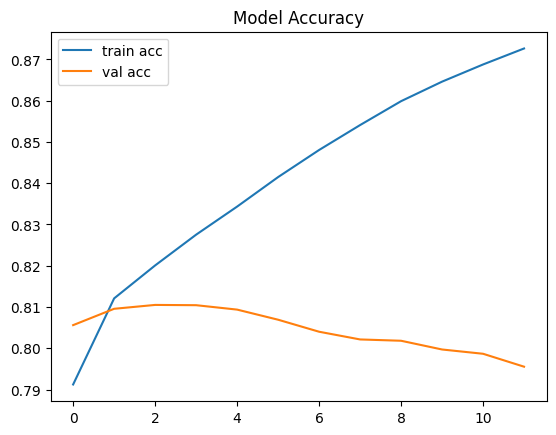

In [20]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()

In [21]:
preds = model.predict(x_test)
preds_binary = (preds > 0.5).astype(int).flatten()

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, preds_binary))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79    159790
           1       0.79      0.80      0.80    160210

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000


Confusion Matrix:
[[126318  33472]
 [ 32013 128197]]


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"\nAccuracy: {accuracy_score(y_test, preds_binary):.4f}")
print(f"Precision: {precision_score(y_test, preds_binary):.4f}")
print(f"Recall: {recall_score(y_test, preds_binary):.4f}")
print(f"F1-Score: {f1_score(y_test, preds_binary):.4f}")


Accuracy: 0.7954
Precision: 0.7930
Recall: 0.8002
F1-Score: 0.7966


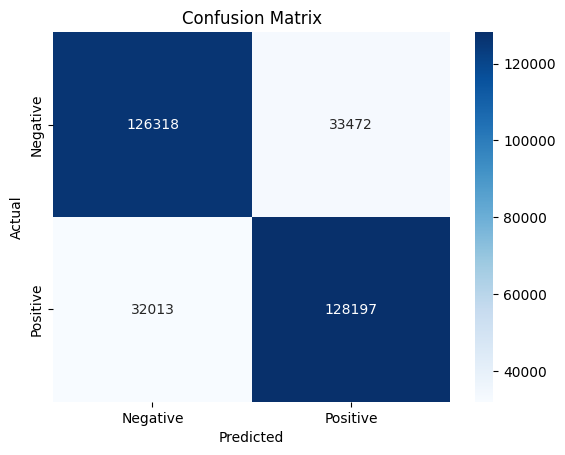

In [24]:
cm = confusion_matrix(y_test, preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---

**Initial training results:** the model can be improved. Will try again.  
**Second attempt:** model improved slightly. Will try again.  
**Third attempt:** tried adding more epochs and batches. Will try again.  
**Fourth attempt:** used lemmatization, better results. Will try again.
**Fifth attempt:** improved stopword removal, model now performing decently. Will try again.

---

**To do:**
- experiment on emojis.
- perform cross validation and hyperparameter tuning.